In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ltfs-finhack3/train_bureau.csv
/kaggle/input/ltfs-finhack3/train_data.csv
/kaggle/input/ltfs-finhack3/test_data.csv
/kaggle/input/ltfs-finhack3/test_bureau.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
train_data = pd.read_csv("/kaggle/input/ltfs-finhack3/train_data.csv", sep='|')
train_bureau = pd.read_csv("/kaggle/input/ltfs-finhack3/train_bureau.csv", sep='|')

test_data = pd.read_csv("/kaggle/input/ltfs-finhack3/test_data.csv", sep='|')
test_bureau = pd.read_csv("/kaggle/input/ltfs-finhack3/test_bureau.csv", sep='|')


In [4]:
train_data = train_data.drop('Top-up Month', axis=1)

In [5]:
cat_cols = list(train_data.select_dtypes('object').columns)
cat_cols

['Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'Area',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'SEX',
 'City',
 'State']

In [6]:
for col in train_data.columns:
    if col not in cat_cols:
        print(col)

ID
BranchID
Tenure
AssetCost
AmountFinance
DisbursalAmount
EMI
AssetID
ManufacturerID
SupplierID
LTV
AGE
MonthlyIncome
ZiPCODE


In [7]:
for col in cat_cols:
    if col != 'Top-up Month':
        print(col)
        train_data[col] = train_data[col].fillna('UNK')
        test_data[col] = test_data[col].fillna('UNK')
        
#         le = LabelEncoder()
#         le.fit(list(train_data[col]) + list(test_data[col]))
#         train_data[col] = le.transform(train_data[col])
#         test_data[col] = le.transform(test_data[col])
        

Frequency
InstlmentMode
LoanStatus
PaymentMode
Area
DisbursalDate
MaturityDAte
AuthDate
SEX
City
State


In [8]:
for col in ['AGE', 'MonthlyIncome', 'ZiPCODE', 'ManufacturerID']:
    print(col)
    train_data[col] = train_data[col].fillna(-999)
    test_data[col] = test_data[col].fillna(-999)
    

AGE
MonthlyIncome
ZiPCODE
ManufacturerID


In [9]:
features = list(train_data.columns)
target = 'dataset_label'

In [10]:
train_data['dataset_label'] = 0
test_data['dataset_label'] = 1

In [11]:
all_cols = features + [target]

In [12]:
def create_adversarial_data(df_train, df_test, cols, N_val=10000):
    df_master = pd.concat([df_train[cols], df_test[cols]], axis=0)
    adversarial_test = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

In [13]:
adversarial_train, adversarial_test = create_adversarial_data(train_data, test_data, all_cols, 20000)
adversarial_train.shape, adversarial_test.shape

((119958, 26), (20000, 26))

In [14]:
from catboost import Pool, CatBoostClassifier

In [15]:
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target],
    cat_features=cat_cols
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
    cat_features=cat_cols
)

In [16]:
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
#     'task_type': 'GPU', # if you have GPU
    'devices': '2', 
}

In [17]:
model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

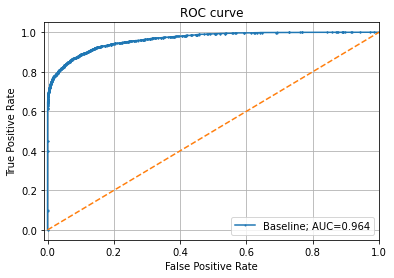

In [20]:
plot_roc(
    [holdout_data.get_label()],
    [model.predict_proba(holdout_data)[:,1]],
    ['Baseline']
)

In [21]:
import scipy.stats as stats
import shap
shap.initjs()

In [22]:
def plot_importances(model, holdout_data, features):
    explainer = shap.TreeExplainer(model)

    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')


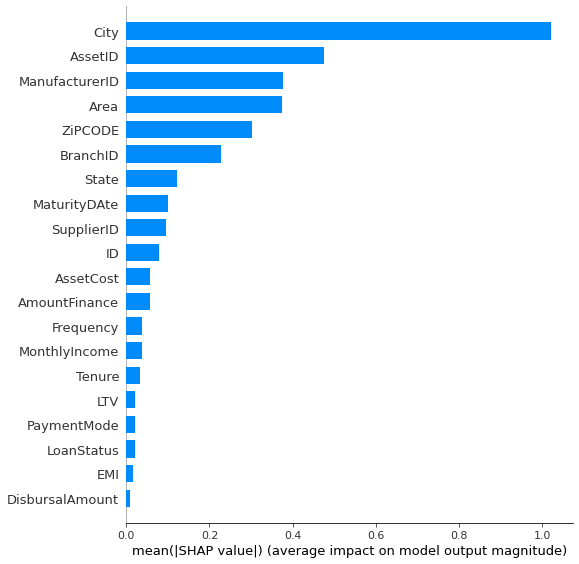

In [23]:
plot_importances(model, holdout_data, features)

In [24]:
params2 = dict(params)
params2.update({"ignored_features": ['City']})
model2 = CatBoostClassifier(**params2)
_ = model2.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

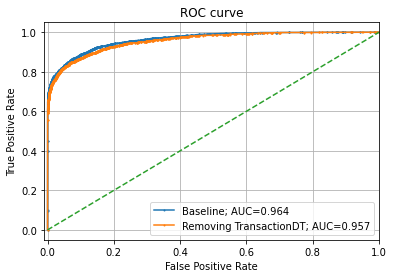

In [25]:
plot_roc(
    [holdout_data.get_label()]*2,
    [model.predict_proba(holdout_data)[:,1], model2.predict_proba(holdout_data)[:,1]],
    ['Baseline', 'Removing TransactionDT']
)

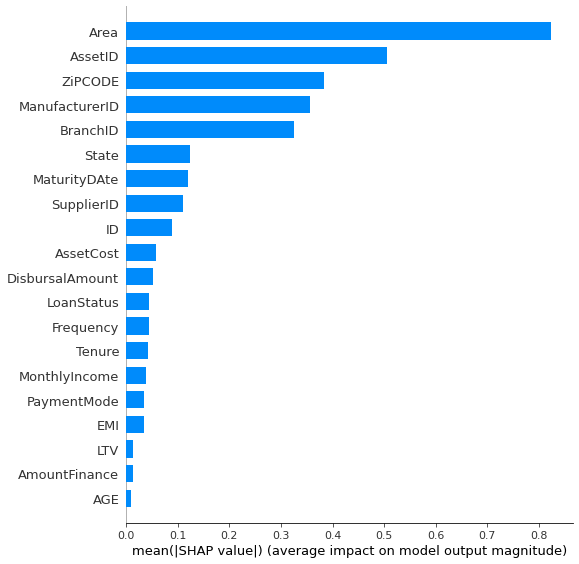

In [26]:
plot_importances(model2, holdout_data, features)

In [27]:
params3 = dict(params)
params3.update({"ignored_features": ['City', 
                                     'Area', 
                                     'AssetID', 
                                     'ZiPCODE', 
                                     'BranchID', 
                                     'ManufacturerID', 
                                     'State', 
                                     'ID', 
                                     'MaturityDAte',
                                     'SupplierID']})
model3 = CatBoostClassifier(**params3)
_ = model3.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

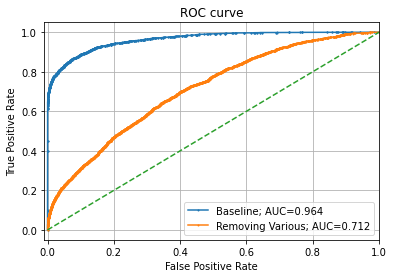

In [28]:
plot_roc(
    [holdout_data.get_label()]*2,
    [model.predict_proba(holdout_data)[:,1], model3.predict_proba(holdout_data)[:,1]],
    ['Baseline', 'Removing Various']
)

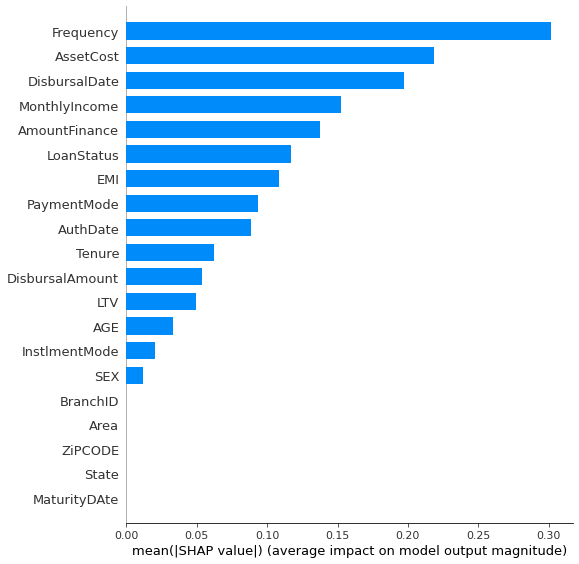

In [29]:
plot_importances(model3, holdout_data, features)